# **Demonstrate how the summary statistics of NN weights evolve as the NN gets trained over epochs for a problem of your choice**


*   This tutorial guides you through analyzing and visualizing how the weights of a neural network change during training, providing insights into the learning process.
* A neural network is a series of interconnected nodes, or neurons, that use weights and activation functions to process and transmit information, learning to perform tasks by adjusting these parameters.

<div style="text-align:center;">
    <img src="NN_overview.png" style="width:800px;height:400px;">
</div>

*  During training, a neural network updates its weight parameters using a learning algorithm, like gradient descent, that adjusts weights to minimize the loss function based on the error feedback calculated through backpropagation.   
*  We'll use the MNIST handwritten digit classification problem as an example, but the concepts can be applied to various deep learning tasks.

# 1. Setup and Data Preparation

*   We import necessary libraries like TensorFlow, Keras, matplotlib, and seaborn.
*  The MNIST dataset is loaded and preprocessed by scaling pixel values and adding a channel dimension.


In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Preprocess data
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# 2. Model Definition
*   We define a simple convolutional neural network with two convolutional layers followed by max-pooling and a final dense layer for classification.
*   The Adam optimizer and sparse categorical cross-entropy loss are chosen for training.



In [2]:
# Define the model
model = keras.Sequential(
    [
        keras.Input(shape=(28, 28, 1)),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(10, activation="softmax"),
    ]
)

# Optimizer and loss
optimizer = keras.optimizers.Adam(learning_rate=0.001)
loss_fn = keras.losses.SparseCategoricalCrossentropy()

# 3. Training Loop with Weight Statistics Tracking
*   We implement the training loop, iterating over epochs and batches of data to update the model's weights.
*  At the end of each epoch, we calculate and store summary statistics (mean, standard deviation, minimum, maximum) for the weights of each layer.



In [3]:
# Training loop
weight_stats_history = []
num_epochs = 5  # Adjust as needed

weight_stats = []
for layer in model.layers:
    for weights in layer.weights:
        weight_stats.append({
            'layer_name': layer.name,
            'mean': tf.math.reduce_mean(weights).numpy(),
            'std': tf.math.reduce_std(weights).numpy(),
        })
weight_stats_history.append(weight_stats)

for epoch in range(num_epochs):
    for batch in range(x_train.shape[0] // 32):
        with tf.GradientTape() as tape:
            predictions = model(x_train[batch * 32 : (batch + 1) * 32])
            loss = loss_fn(y_train[batch * 32 : (batch + 1) * 32], predictions)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    # Calculate and store weight statistics for the epoch
    weight_stats = []
    for layer in model.layers:
        for weights in layer.weights:
            weight_stats.append({
                'layer_name': layer.name,
                'mean': tf.math.reduce_mean(weights).numpy(),
                'std': tf.math.reduce_std(weights).numpy(),
            })
    # print(weight_stats)
    weight_stats_history.append(weight_stats)

    # Print epoch results
    print(f"Epoch: {epoch+1}, Loss: {loss.numpy():.4f}")



separated_stats_history = []
for epoch_stats in weight_stats_history:
    separated_epoch_stats = {}
    for idx, stat in enumerate(epoch_stats):
        layer_name = stat['layer_name']
        if idx % 2 == 0:  # Even indices assumed to be weights
            separated_epoch_stats.setdefault(layer_name, {}).update({
                'weight_mean': stat['mean'], 'weight_std': stat['std']
            })
        else:  # Odd indices assumed to be biases
            separated_epoch_stats.setdefault(layer_name, {}).update({
                'bias_mean': stat['mean'], 'bias_std': stat['std']
            })
    separated_stats_history.append(separated_epoch_stats)

Epoch: 1, Loss: 0.0218
Epoch: 2, Loss: 0.0026
Epoch: 3, Loss: 0.0010
Epoch: 4, Loss: 0.0004
Epoch: 5, Loss: 0.0004


* Plotting graph between Weight-mean of each layer Vs Epoch
    and between Bias-mean of each layer Vs Epoch

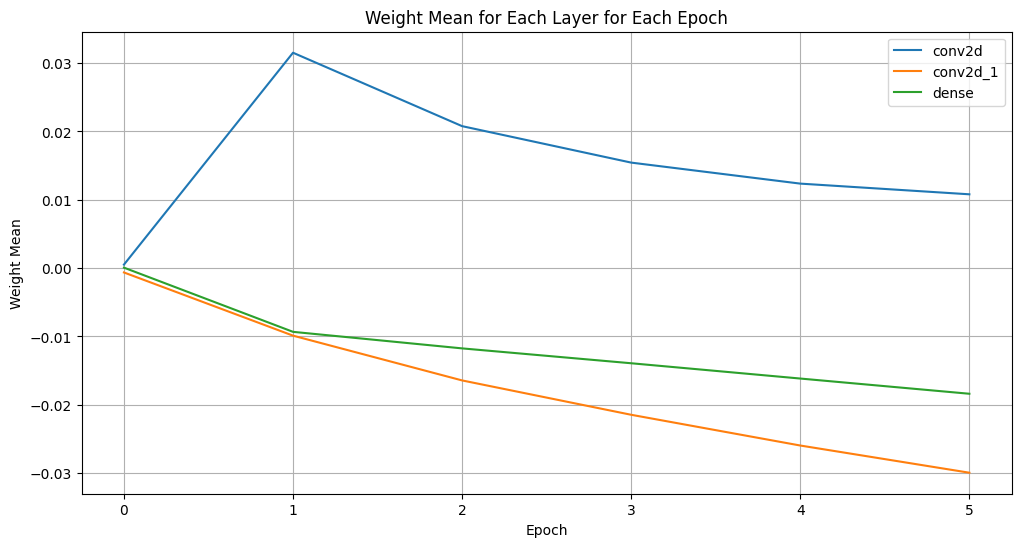

In [7]:
# Visualization (example for mean weight)
# Extracting layer names
layers = list(separated_stats_history[0].keys())

# Initialize lists to store weight and bias means for each layer
weight_means = {layer: [] for layer in layers}
bias_means = {layer: [] for layer in layers}

# Extract weight means for each layer for each epoch
for epoch_data in separated_stats_history:
    for layer, stats in epoch_data.items():
        weight_mean = stats['weight_mean']
        weight_means[layer].append(weight_mean)
        bias_mean = stats['bias_mean']
        bias_means[layer].append(bias_mean)

# Plotting weight mean for each layer for each epoch
plt.figure(figsize=(12, 6))

for layer, means in weight_means.items():
    plt.plot(range(len(means)), means, label=layer)

plt.xlabel('Epoch')
plt.ylabel('Weight Mean')
plt.title('Weight Mean for Each Layer for Each Epoch')
plt.legend()
plt.grid(True)
plt.show()

* The graph illustrates the evolution of weights versus epochs. Initially, we observe a rapid rate of change in weights, which gradually decreases over time, suggesting convergence. However, the graph indicates that convergence has not yet been achieved, implying that further training epochs may be necessary to reach convergence.

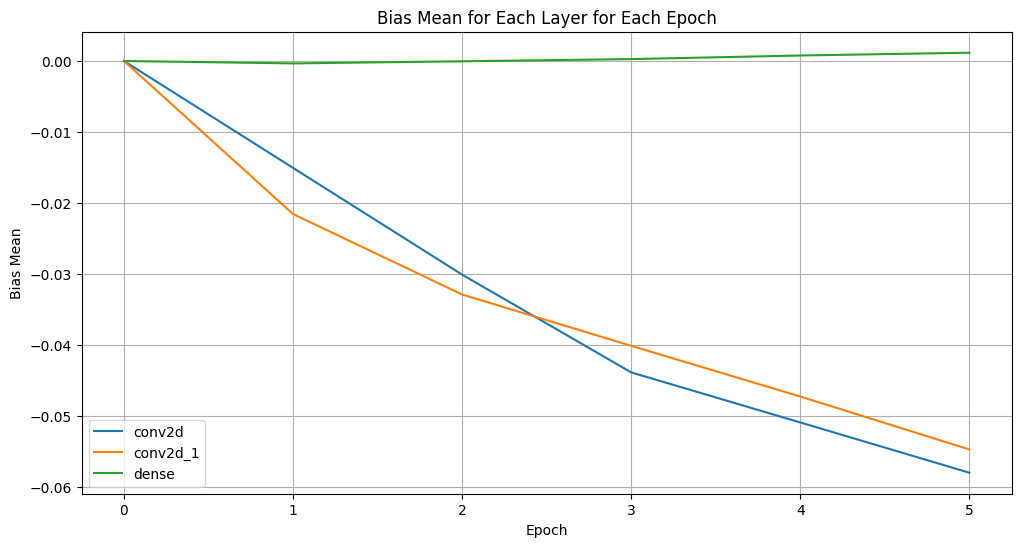

In [8]:
# Plotting weight mean for each layer for each epoch
plt.figure(figsize=(12, 6))

for layer, means in bias_means.items():
    plt.plot(range(len(means)), means, label=layer)
    
plt.xlabel('Epoch')
plt.ylabel('Bias Mean')
plt.title('Bias Mean for Each Layer for Each Epoch')
plt.legend()
plt.grid(True)
plt.show()

* The bias values for the last layer hardly change indicating quicker convergence of them. Whereas, bias values for other layers decrease as number of epochs increase.

# Effect of Number of Iterations on Weights' evolution over epochs
* The number of iterations, or training epochs, plays a crucial role in shaping the evolution of weights in a neural network. With a higher number of iterations, the model has more opportunities to adjust its weights in response to the training data, potentially leading to better convergence towards optimal weights.
* Adequate iterations allow the model to stabilize its weights, leading to improved generalization performance.

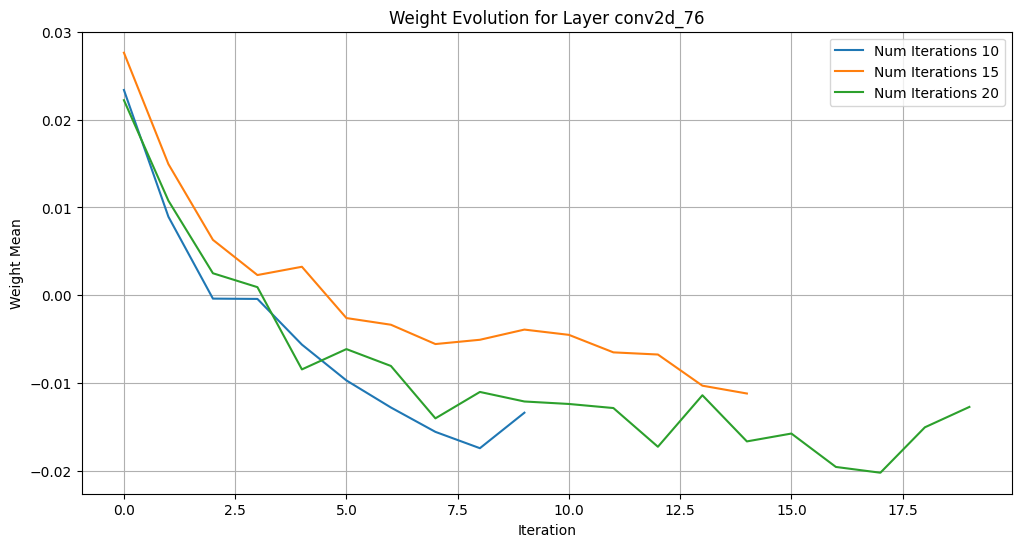

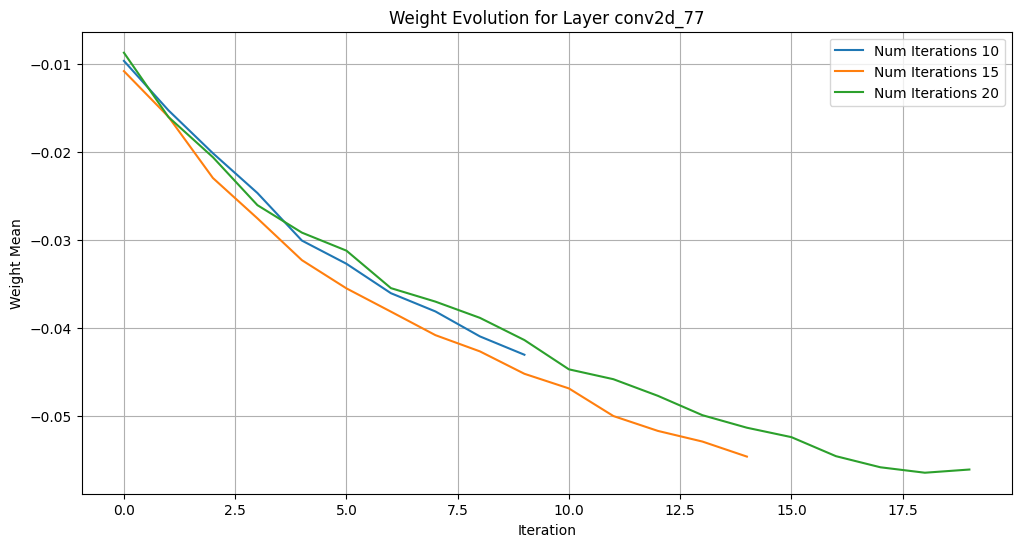

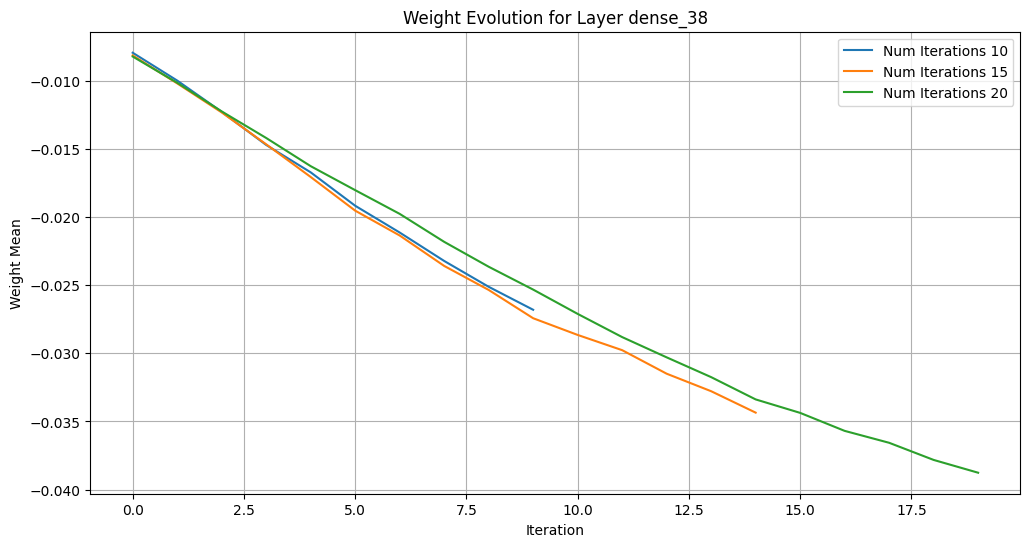

In [25]:
import numpy as np 

def create_model():
    model = keras.Sequential(
        [
            keras.Input(shape=(28, 28, 1)),
            layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Flatten(),
            layers.Dense(10, activation="softmax"),
        ]
    )
    return model

def train_model_with_weights(batch_size, num_epochs):
    model = create_model()
    model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
    
    # Dictionary to store weights for each layer at each epoch, with layer names as keys
    weights_per_epoch = {layer.name: [] for layer in model.layers}
    
    # Training loop
    for epoch in range(num_epochs):
        history = model.fit(x_train, y_train, batch_size=batch_size, epochs=1, verbose=0)
        
        # Record weights for each layer
        for i, layer in enumerate(model.layers):
            for weights in layer.weights:
                weights_per_epoch[layer.name].append(tf.math.reduce_mean(weights).numpy())
                break

    weights_per_epoch = {layer_name: weights for layer_name, weights in weights_per_epoch.items() if weights}

    # print(weights_per_epoch)
    return weights_per_epoch

# Train the model with fixed batch size and varying number of iterations
batch_size = 32
num_epochs_list = [10, 15, 20]  # Varying number of iterations

weights_per_iteration = {}

for num_epochs in num_epochs_list:
    weights_per_iteration[num_epochs] = train_model_with_weights(batch_size, num_epochs)
    # print(weights_per_iteration[num_iterations])

# Plot weight evolution for each layer for each number of iterations
num_layers = 3

for layer_idx in range(num_layers):
    plt.figure(figsize=(12, 6))
    for num_iterations, weights_dict in weights_per_iteration.items():
        if layer_idx < len(weights_dict):
            layer_name = list(weights_dict.keys())[layer_idx]
            layer_weights = weights_dict[layer_name]
            plt.plot(range(num_iterations), layer_weights, label=f'Num Iterations {num_iterations}')
    
    plt.xlabel('Iteration')
    plt.ylabel('Weight Mean')
    plt.title(f'Weight Evolution for Layer {layer_name}')
    plt.legend()
    plt.grid(True)
    plt.show()


* In the provided graphs depicting the weight evolution of three layers across different number of epochs, a clear trend emerges: as the number of epochs increases, the rate of change decreases towards the end, signaling convergence.
* As expected, larger number of epochs typically result in quicker convergence.

# Effect of Batch Size on Weights' evolution over epochs
*  The choice of batch size influences how weights evolve during neural network training. 
* Larger batch sizes typically result in smoother weight updates over epochs due to reduced noise in gradient estimates, while smaller batch sizes may lead to more erratic weight changes as gradients are computed from fewer data points at each step.
* Also,  Larger batch sizes often result in faster convergence as they provide more stable gradient estimates, allowing the model to quickly adjust its weights towards optimal values.
* While larger batch sizes may lead to faster convergence, they may also increase the risk of overfitting as they tend to produce smoother weight updates that could memorize noise in the training data. On the other hand, smaller batch sizes may encourage better generalization by introducing more randomness in weight updates and preventing the model from memorizing noise.

{'conv2d_66': [0.041702237, 0.024904164, 0.015643798, 0.01182771, 0.009033742], 'conv2d_67': [-0.011431647, -0.014419053, -0.018880937, -0.024693165, -0.027666964], 'dense_33': [-0.007998421, -0.010028546, -0.011939113, -0.013773554, -0.016216671]}
{'conv2d_68': [0.054253254, 0.05352415, 0.05223689, 0.05018742, 0.047298975], 'conv2d_69': [-0.0011527018, -0.0030292338, -0.0052230675, -0.0065270956, -0.007069921], 'dense_34': [-0.0047273976, -0.005224432, -0.0056586317, -0.0059858942, -0.006335578]}
{'conv2d_70': [0.031892426, 0.035533205, 0.038132947, 0.039672337, 0.042035863], 'conv2d_71': [0.005467449, 0.0036511985, 0.0023876934, 0.0013147797, 0.00078467827], 'dense_35': [-0.0031169732, -0.0031121254, -0.0031605996, -0.003276955, -0.0033407472]}


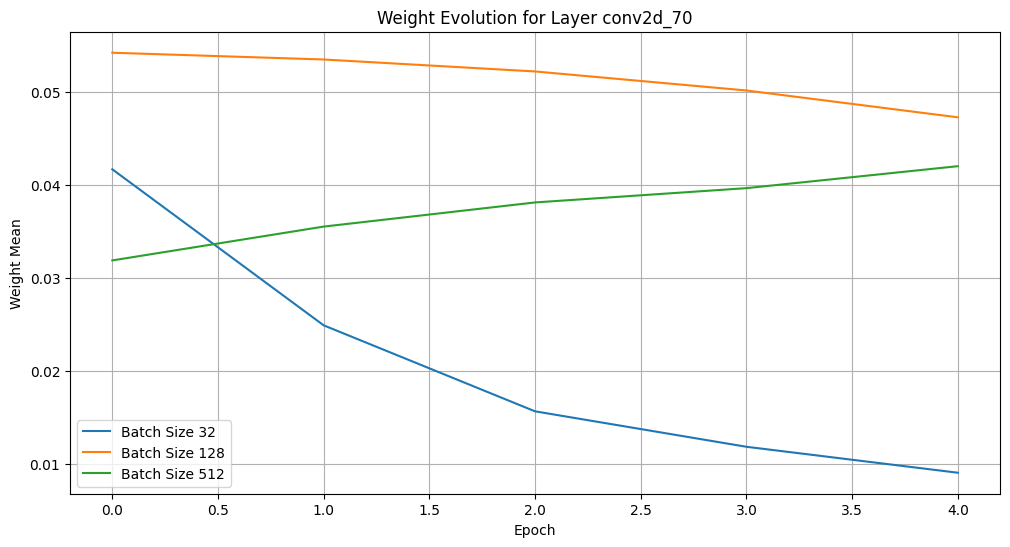

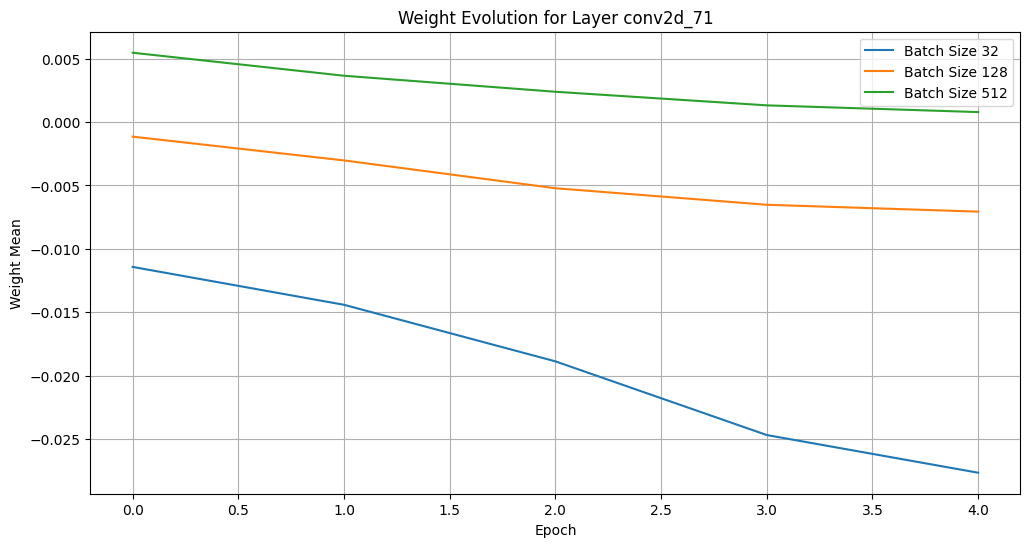

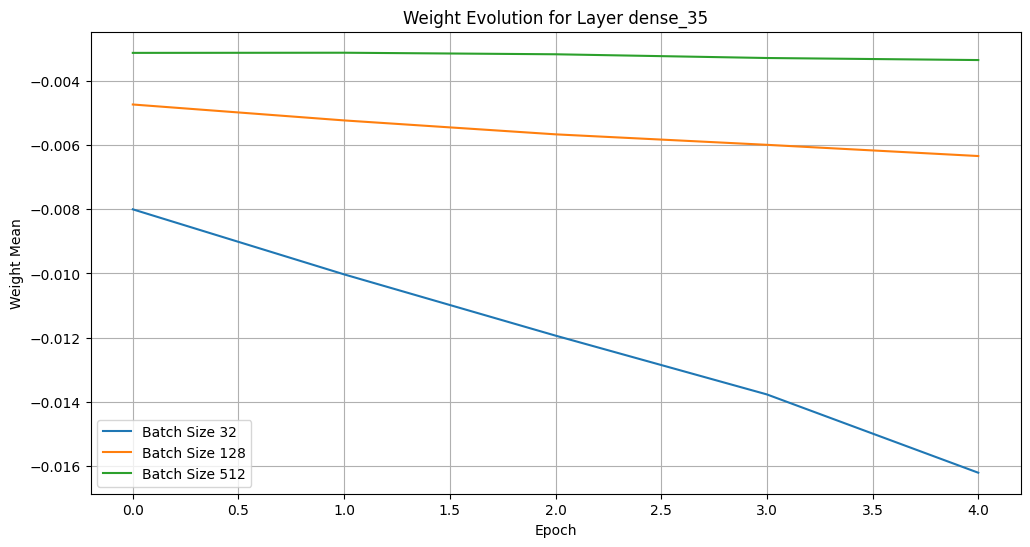

In [24]:
import numpy as np 

def create_model():
    model = keras.Sequential(
        [
            keras.Input(shape=(28, 28, 1)),
            layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Flatten(),
            layers.Dense(10, activation="softmax"),
        ]
    )
    return model

def train_model_with_weights(batch_size):
    model = create_model()
    model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
    
    # Dictionary to store weights for each layer at each epoch, with layer names as keys
    weights_per_epoch = {layer.name: [] for layer in model.layers}
    
    # Training loop
    for epoch in range(5):
        history = model.fit(x_train, y_train, batch_size=batch_size, epochs=1, verbose=0)
        
        # Record weights for each layer
        for i, layer in enumerate(model.layers):
            for weights in layer.weights:
                weights_per_epoch[layer.name].append(tf.math.reduce_mean(weights).numpy())
                break

    weights_per_epoch = {layer_name: weights for layer_name, weights in weights_per_epoch.items() if weights}

    # print(weights_per_epoch)
    return weights_per_epoch

# Train the model with different batch sizes and record weights
batch_sizes = [32, 128, 512]
weights_per_batch = {}

for batch_size in batch_sizes:
    weights_per_batch[batch_size] = train_model_with_weights(batch_size)
    print(weights_per_batch[batch_size])

# Plot weight evolution for each layer for each batch size
num_epochs = 5
num_layers = 3
print(num_layers)
for layer_idx in range(num_layers):
    plt.figure(figsize=(12, 6))
    for batch_size, weights_per_epoch in weights_per_batch.items():
        layer_weights = [epoch[layer_idx] for epoch in weights_per_epoch]
        
        plt.plot(range(num_epochs), layer_weights, label=f'Batch Size {batch_size}')
    
    plt.xlabel('Epoch')
    plt.ylabel('Weight Mean')
    plt.title(f'Weight Evolution for Layer {layer_idx}')
    plt.legend()
    plt.grid(True)
    plt.show()

* In the provided graphs depicting the weight evolution of three layers across different batch sizes, a clear trend emerges: as the batch size increases, the curves tend to flatten out, signaling faster convergence. Additionally, it's noticeable that with larger batch sizes, the mean weight values for a given epoch are higher compared to those for smaller batch sizes.
* As expected, larger batch sizes typically result in smoother weight updates over epochs due to reduced noise in gradient estimates